In [10]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches
using LaTeXStrings

In [183]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

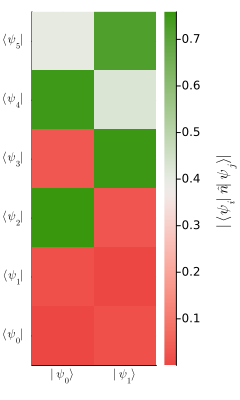

In [297]:
# α = 1
# Es, ψs = eigs(KinPot12 + α .* Potential3, which=:SR,nev=9)
using Plots.PlotMeasures
plt = heatmap(abs.(ψs[:,1:6]'*kron(Id,n)*ψs[:,1:2]),
        c=cgrad(:diverging_gwr_55_95_c38_n256,rev=true),
        size=(240,400),lw=5,colorbar_title="\n"*L"$|\langle \psi_i|\hat{n}|\psi_j\rangle|$",right_margin=20px,
        # title_fontsize=20
        xticks=((1, 2), (L"$|\psi_0\rangle$", L"$|\psi_1\rangle$")),
        yticks=((1,2,3,4,5,6), (L"$\langle\psi_0|$", L"$\langle\psi_1|$", L"$\langle\psi_2|$", L"$\langle\psi_3|$", L"$\langle\psi_4|$", L"$\langle\psi_5|$")),
        # ylabel=L"i",#L"$\psi_i$",
        # xlabel=L"j",#L"$\psi_j$"
)
# savefig(plt,"CouplingStrengths.pdf")

In [280]:
N = 100
phi_range = LinRange(-pi,pi,N)
Id = sparse(I, N, N)
expm = spdiagm(exp.(im .*phi_range))
diff = -im/(2*(phi_range[2] - phi_range[1])) .* (-spdiagm(-1 => ones(N - 1)) + spdiagm(1 => ones(N - 1)))
# diff = -im/(phi_range[2] - phi_range[1]) .* (-spdiagm(ones(N)) + spdiagm(1 => ones(N - 1)))
ddiff = -1/(phi_range[2] - phi_range[1])^2 .* (spdiagm(-1 => ones(N - 1)) + spdiagm(1 => ones(N - 1)) - 2 .* spdiagm(0 => ones(N)))

# diff = -im*(phi_range[2] - phi_range[1]) .* (-spdiagm(ones(N)) + spdiagm(1 => ones(N - 1)))
# ddiff = -1 .* (spdiagm(-1 => ones(N - 1)) + spdiagm(1 => ones(N - 1)) - 2 .* spdiagm(0 => ones(N)))
E = 2pi*E_J_GHz
# H0 = 4*E*E_C * (kron(ddiff, Id) + kron(Id, ddiff)) - E*E_J * (kron((expm + expm')/2,Id) + kron(Id, (expm + expm')/2))

EC1 = 1*E#*E_C
EC2 = 1*E#*E_C
EC3 = E*1*E_C
ESUMsqrd = 1/(1/(EC1*EC2) + 1/(EC1*EC3) + 1/(EC2*EC3))
H0 = 4*ESUMsqrd*(kron(ddiff, Id)/EC2 + kron(Id, ddiff)/EC1 + EC3\(kron(diff, Id) + kron(Id, diff))^2) - E*E_J * (kron((expm + expm')/2,Id) + kron(Id, (expm + expm')/2))
Hphi = -E*E_J * (exp(im*phi_ext) .* kron(expm,expm') + exp(-im*phi_ext) .* kron(expm',expm))/2

α = 1#*(phi_range[2] - phi_range[1])^2
Es, ψs = eigs(H0 + α .* Hphi, which=:SR,nev=2,maxiter=1000)
# Es, ψs = eigs(H0 + α .* Hphi, which=:SR)
# ;

(ComplexF64[-15.717846992316682 + 8.176064984558786e-14im, -14.09404988615647 + 3.765979119355617e-14im], ComplexF64[-7.38524021386328e-6 - 3.032754551121897e-5im -8.092653315525146e-6 - 3.085353071642161e-5im; -5.375544867741185e-6 - 2.207471617790778e-5im 1.5549491406064996e-6 + 5.928299311312297e-6im; … ; 1.510496320917952e-6 + 6.202864712442639e-6im -5.787633968055539e-6 - 2.2065561867738e-5im; -7.385240213587948e-6 - 3.032754551085232e-5im -8.09265331564386e-6 - 3.0853530716124934e-5im], 2, 432, 7778, ComplexF64[149.56442033795543 + 331.0064819405568im, -110.766010757031 + 373.95087147189025im, 21.001369242893215 + 88.37446552136392im, 390.59591669068806 - 48.44387817259936im, -428.3534474164775 + 156.18163187925012im, -105.1392182017229 + 17.118737419694323im, -18.19756592767509 - 240.64077479639636im, 265.6028998043066 + 191.73003104864097im, -51.80808549577549 - 69.23610487100946im, -29.988712061018724 + 201.73920666991697im  …  -18.829568221215855 - 120.99241769781563im, -278.

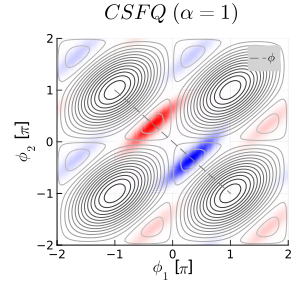

In [291]:
function V2d(phi1,phi2)
    -E_J*(cos(phi1)+cos(phi2)+α*cos(phi1-phi2+phi_ext))
end

phi_range = LinRange(-pi,pi,N)
plt = heatmap(phi_range/pi,phi_range/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,
        )

# phi_range = LinRange(-pi,pi,N)
heatmap!((phi_range.-2pi)/pi,phi_range/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,alpha=0.2
)
heatmap!((phi_range)/pi,(phi_range.-2pi)/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,alpha=0.2
)
heatmap!((phi_range.+2pi)/pi,phi_range/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,alpha=0.2
)
heatmap!((phi_range)/pi,(phi_range.+2pi)/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,alpha=0.2
)
heatmap!((phi_range.+2pi)/pi,(phi_range.-2pi)/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,alpha=0.2
)
heatmap!((phi_range.-2pi)/pi,(phi_range.+2pi)/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
        c=:bwr,alpha=0.2
)
# phi_range = LinRange(-pi,pi,N)
# plt = heatmap(phi_range/pi,phi_range/pi,reshape((abs2.(ψs[:,1])-abs2.(ψs[:,2]).+0.0002)*2000,100,100), #.+0.0025
#         c=:bwr,
#         )
# plt = heatmap(phi_range/pi,phi_range/pi,reshape((abs2.(ψs[:,1]))*2000,100,100),alpha=0.4,c=:bwr
#         )
# heatmap!(phi_range/pi,phi_range/pi,reshape((abs2.(ψs[:,2]))*2000,100,100),alpha=0.4
#         )
# heatmap!(phi_range/pi,phi_range/pi,reshape(abs2.(ψs[:,2])*2000,100,100),
#         c=:Reds_3,
#         )
phi_range = LinRange(-2pi,2pi,N)
contour!(phi_range/pi,phi_range/pi,cat([[V2d(phi1,phi2) for phi1 in phi_range] for phi2 in phi_range]...,dims=2),
        levels=25,c=:binary,size=(300,300),colorbar=nothing,background_color_legend =:lightgray,foreground_color_legend = nothing,
        xlabel=L"$\phi_1$ [$\pi$]",
        title=L"CSFQ"*" "*L"$(\alpha=1)$",
        ylabel=L"$\phi_2$ [$\pi$]",ylim=(-2,2),xlim=(-2,2))
plot!([-1,1],[1,-1],ls=:dash,c=:gray,label=L"$\phi$")

# savefig(plt,"CSFQalpha1_eigstates2d2.pdf")

In [227]:
["#0F956F","#BA2936",1,4][2]

"#BA2936"

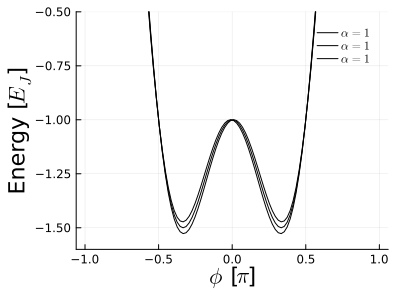

In [299]:
α = 1
function V(phi)
    -E_J*(2*cos(phi) + α * cos(2*phi + 1.01pi))
end
phi_range = LinRange(-pi,pi,N)
# Es, ψs = eigs(H0 + α .* Hphi, which=:SR,nev=2)
plt = plot!(phi_range/pi,V.(phi_range),ylim=(-1.6,-0.5),color=:black,xlabel=L"$\phi$ [$\pi$]",labelfontsize=15,size=(400,300),
ylabel=L"Energy [$E_J$]",label=L"$\alpha=1$",#*(string(α)*"0")[1:4],
background_color_legend = nothing,foreground_color_legend = nothing,)
# plot!(phi_range/pi,[real(Es[1])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,1],N,N))[end:-1:1,:])*20 .+real(Es[1]/(2pi*E_J_GHz)),label="|"*string(1-1)*L"$\rangle$",alpha=0.8,c="#0F956F")
# plot!(phi_range/pi,[real(Es[2])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,2],N,N))[end:-1:1,:])*20 .+real(Es[2]/(2pi*E_J_GHz)),label="|"*string(2-1)*L"$\rangle$",alpha=0.8,c="#BA2936")

# for (num,level) in enumerate([1,2])
#     print(num)
#     plot!(phi_range/pi,[real(Es[level])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,level],N,N))[end:-1:1,:])*20 .+real(Es[level]/(2pi*E_J_GHz)),label="|"*string(level-1)*L"$\rangle$",c=["#0F956F","#BA2936",1,4][num],alpha=0.8)
# end
# plt

# plot!(phi_range/pi,[real(Es[2])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,2],N,N))[end:-1:1,:])*20 .+real(Es[2]/(2pi*E_J_GHz)),color="#BA2936",label=L"$|\psi_1|^2$")
# plot!(phi_range/pi,[real(Es[1])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,1],N,N))[end:-1:1,:])*20 .+real(Es[1]/(2pi*E_J_GHz)),color="#0F956F",label=L"$|\psi_0|^2$",alpha=0.8)
# savefig(plt,"alpha1_eigenstates0145.pdf")

In [111]:
# anim = Animation()
	
# for α in LinRange(1,0.5,200)
#     function V(phi)
#         -E_J*(2*cos(phi) + α * cos(2*phi + phi_ext))
#     end
#     Es, ψs = eigs(H0 + α .* Hphi, which=:SR)
#     plt = plot(phi_range/pi,V.(phi_range),ylim=(-1.6,-0.5),color=:black,xlabel=L"$\phi$ [$\pi$]",labelfontsize=15,size=(400,300),
#     ylabel=L"Energy [$E_J$]",label=L"$\alpha=$ "*(string(α)*"0")[1:4],
#     background_color_legend = nothing,foreground_color_legend = nothing,)
#     plot!(phi_range/pi,[real(Es[2])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,2],N,N))[end:-1:1,:])*20 .+real(Es[2]/(2pi*E_J_GHz)),color="#BA2936",label=L"$|\psi_1|^2$")
#     plot!(phi_range/pi,[real(Es[1])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,1],N,N))[end:-1:1,:])*20 .+real(Es[1]/(2pi*E_J_GHz)),color="#0F956F",label=L"$|\psi_0|^2$",alpha=0.8)

#     frame(anim, plt)
# end

# gif(anim,"PhiEigstates.gif")

In [94]:
using LaTeXStrings
function V(phi)
    -E_J*(2*cos(phi) + α * cos(2*phi + phi_ext))
end

plt = plot(phi_range/pi,V.(phi_range),ylim=(-1.6,-0.5),color=:black,xlabel=L"$\phi$ [$\pi$]",labelfontsize=15,size=(400,300),
ylabel=L"Energy [$E_J$]",label=nothing,
background_color_legend = nothing,foreground_color_legend = nothing,)
plot!(phi_range/pi,[real(Es[2])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,2],N,N))[end:-1:1,:])*20 .+real(Es[2]/(2pi*E_J_GHz)),color="blue",label=L"$|\psi_1|^2$")
plot!(phi_range/pi,[real(Es[1])/(2pi*E_J_GHz) for i in 1:100],fillrange=diag(abs2.(reshape(ψs[:,1],N,N))[end:-1:1,:])*20 .+real(Es[1]/(2pi*E_J_GHz)),color="red",label=L"$|\psi_0|^2$",alpha=0.8)
# plot!(real.(Es[1:2])./(2pi*E_J_GHz), seriestype=:hline, c=["red","blue"])

# savefig(plt,"alpha07_eigenstates.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\NoAlpha\\alpha07_eigenstates.pdf"

In [81]:
h_times = LinRange(0,30,72+2)[2:end-1]
dt = h_times[2] - h_times[1]
p = readdlm("tmp_paramsmm.txt")[end,:]
function pulse(t)
    # if  t < 10 || t > 20
    #     return 0
    # end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 0)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 30)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end

pulse (generic function with 2 methods)

In [214]:
ψs = eigvecs(Matrix(KinPot12 + Potential3))
ψ0 = ψs[:,1]
ψtarget = ψs[:,2]
H0 = KinPot12 + Potential3

λ0s = []
ls = []

α = 0.03
function H!(du, u, p, t)
    ψ = u[:,1]
    λ = u[:,2]
    ϵ = -1/α*imag(λ'*chargecoupling*ψ)
    miH = -im .* (H0 + ϵ .* chargecoupling)
    du[:,1] = miH * ψ
    du[:,2] = miH * λ
end

# function algorithm(k)
    #initial
ϵ = 2#.5
function f_initial!(du, u, p, t)
    ψ = u[:,1]
    ϵ = pulse(t)
    miH = -im .* (H0 + ϵ .* chargecoupling)
    du[:,1] = miH*ψ
end
forward_prob = ODEProblem(f_initial!, ψ0, (0.0, 30.0))
sol_f = solve(forward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)

ψT = sol_f.u[end][:,1]
infidelity = 1 - abs2(ψtarget'*ψT)
println(infidelity)
push!(ls,copy(infidelity))
λT = ψtarget*ψtarget'*ψT

backward_prob = ODEProblem(H!, cat(ψT,λT,dims=2), (30.0, 0.0))
sol_b = solve(backward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)
λ0 = sol_b.u[end][:,2]
push!(λ0s,copy(λ0))

# for kstep in 1:100
#     forward_prob = ODEProblem(H!, cat(ψ0,λ0,dims=2), (0.0, 30.0))
#     sol_f = solve(forward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)
    
#     ψT = sol_f.u[end][:,1]
#     λT = ψtarget*ψtarget'*ψT

#     infidelity = 1 - abs2(ψtarget'*ψT)
#     push!(ls,copy(infidelity))
#     println(kstep,": ",ls[end])

#     backward_prob = ODEProblem(H!, cat(ψT,λT,dims=2), (30.0, 0.0))
#     sol_b = solve(backward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)
#     λ0 = sol_b.u[end][:,2]
#     push!(λ0s,copy(λ0))
# end
;


0.4710529552266829


In [215]:
for i in 1:20
    forward_prob = ODEProblem(H!, cat(ψ0,λ0s[end],dims=2), (0.0, 30.0))
    sol_f = solve(forward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)

    ψT = sol_f.u[end][:,1]
    λT = ψtarget*ψtarget'*ψT

    infidelity = 1 - abs2(ψtarget'*ψT)
    push!(ls,copy(infidelity))
    println(ls[end])

    backward_prob = ODEProblem(H!, cat(ψT,λT,dims=2), (30.0, 0.0))
    sol_b = solve(backward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)
    λ0 = sol_b.u[end][:,2]
    push!(λ0s,copy(λ0))
end

0.9971363008092383


0.622009249745708


0.9983098651110961


0.9780006450958239


0.9470575044515899


0.9863702650172659


0.9688065439501794


0.9462267921469663


0.9504388010723823


0.9735537936760531


0.9971170652406917


0.7625151289625114


0.9983653150759267


0.5127549298436205


0.9966621815176641


0.707227876036649


0.9998603187045272


0.9993089181092109


0.9783245988438625


0.9146636988590037

In [212]:
for i in 1:20
    α = new_alpha
    function H!(du, u, p, t)
        ψ = u[:,1]
        λ = u[:,2]
        ϵ = -1/α*imag(λ'*chargecoupling*ψ)
        miH = -im .* (H0 + ϵ .* chargecoupling)
        du[:,1] = miH * ψ
        du[:,2] = miH * λ
    end
    forward_prob = ODEProblem(H!, cat(ψ0,λ0,dims=2), (0.0, 30.0))
    sol_f = solve(forward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)

    ψT = sol_f.u[end][:,1]
    λT = ψtarget*ψtarget'*ψT

    infidelity = 1 - abs2(ψtarget'*ψT)
    push!(ls,copy(infidelity))
    println(ls[end])

    backward_prob = ODEProblem(H!, cat(ψT,λT,dims=2), (30.0, 0.0))
    sol_b = solve(backward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)
    λ0 = sol_b.u[end][:,2]
    push!(λ0s,copy(λ0))

    prob = ODEProblem(H!, cat(ψ0,λ0,dims=2), (0.0, 30.0))
    sol = solve(prob, save_everystep=true, reltol=1e-8, abstol=1e-8)

    new_alpha = sqrt(sum([imag(sol.u[i][:,2]'*chargecoupling*sol.u[i][:,1])^2 for i in 1:size(sol.t)[1]])
    /sum([pulse(t) for t in sol.t]))
end

0.9042485293202366


0.9800472950713947


0.9611402132249667


0.9738808512813676


0.9994711419554414


0.9881110675102169


0.9673289232454577


0.9726254062886587


0.9890624421846755


0.9970830823313338


0.9323688529222427


0.9140832325091417


0.9763708903738078


0.9981939340638311


0.9824899950703562


0.9776021319676483


0.9893714295898053


0.9930040167631369


0.9909440007669352


0.9868488752708937

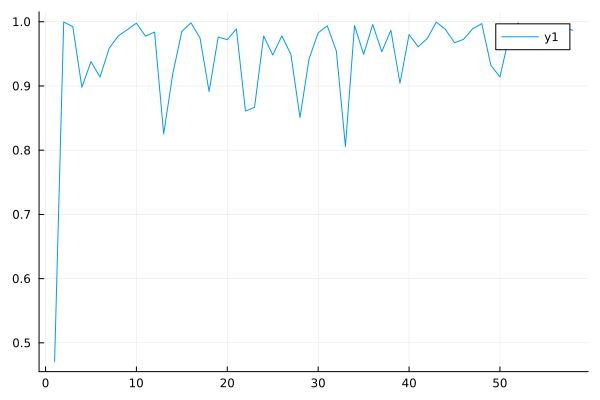

In [213]:
# size(λ0s)
plot(ls)

In [208]:
times = LinRange(0,30,1000)
prob = ODEProblem(H!, cat(ψ0,copy(λ0s[end]),dims=2), (0.0, 30.0))
sol = solve(prob, save_everystep=true, reltol=1e-8, abstol=1e-8)
# λ0 = sol_b.u[end][:,2]
;

In [209]:
new_alpha = sqrt(sum([imag(sol.u[i][:,2]'*chargecoupling*sol.u[i][:,1])^2 for i in 1:size(sol.t)[1]])
/sum([pulse(t) for t in sol.t]))

0.09822341849070995

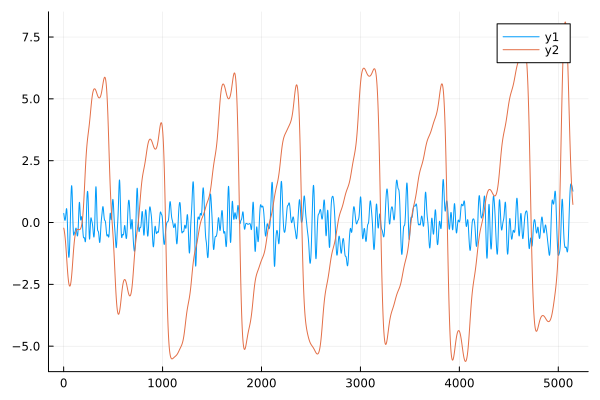

In [197]:
# plot([-1*imag(sol.u[i][:,2]'*chargecoupling*sol.u[i][:,1]) for i in 1:1000])
plot([-1/new_alpha*imag(sol.u[i][:,2]'*chargecoupling*sol.u[i][:,1]) for i in 1:size(sol.t)[1]])
plot!([pulse(t) for t in sol.t])

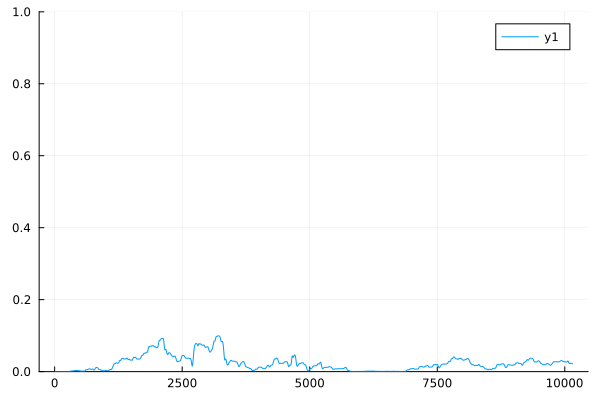

In [193]:
# occ =[abs2.(ψs[:,1:6]'*sol.u[i][:,1]) for i in 1:size(sol.t)[1]] 
plot([occ[i][2] for i in 1:size(sol.t)[1]],ylim=(0,1))
# reshape(occ,(size(sol.t)[1],289))
# scatter(sum(occ,dims=1))

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191


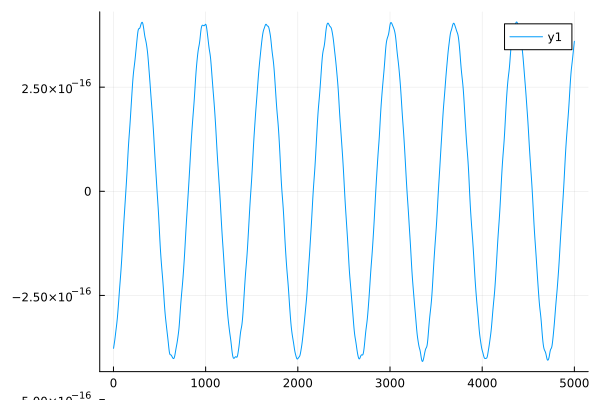

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\jv97\.julia\packages\PlotUtils\M092a\src\ticks.jl:191


In [30]:
ψs = eigvecs(Matrix(KinPot12 + Potential3))
ψ0 = ψs[:,1]
ψtarget = ψs[:,2]
H0 = KinPot12 + Potential3

λ0s = []
ls = []

E0 = 
function H!(du, u, α, t)
    ψ = u[:,1]
    λ = u[:,2]
    ϵ = -1/α*imag(λ'*chargecoupling*ψ)
    miH = -im .* (H0 + ϵ .* chargecoupling)
    du[:,1] = miH * ψ
    du[:,2] = miH * λ
end

# function algorithm(k)
    #initial
ϵ = 2#.5
function f_initial!(du, u, p, t)
    ψ = u[:,1]
    miH = -im .* (H0 + ϵ .* chargecoupling)
    du[:,1] = miH*ψ
end
forward_prob = ODEProblem(f_initial!, ψ0, (0.0, 30.0))
sol_f = solve(forward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)

ψT = sol_f.u[end][:,1]
infidelity = 1 - abs2(ψtarget'*ψT)
println(infidelity)
push!(ls,copy(infidelity))
λT = ψtarget*ψtarget'*ψT

backward_prob = ODEProblem(H!, cat(ψT,λT,dims=2), (30.0, 0.0))
sol_b = solve(backward_prob, save_everystep=false, reltol=1e-8, abstol=1e-8)
λ0 = sol_b.u[end][:,2]
push!(λ0s,copy(λ0))

In [9]:
# h_times = LinRange(0,30,200+2)[2:end-1]
# dt = h_times[2] - h_times[1]
# function pulse(p, t)
#     # if  t < 10 || t > 20
#     #     return 0
#     # end
#     out = 0
#     w_start = exp( - 5/(2*dt^2) * (t - 0)^2)
#     w_end = exp( - 5/(2*dt^2) * (t - 30)^2)
#     w_sum = w_start + w_end
#     for (i, ht) in enumerate(h_times)
#         w = exp( - 5/(2*dt^2) * (t - ht)^2)
#         out += p[i] * w
#         w_sum += w
#     end
#     # envelope(t)*out/w_sum
#     out/w_sum
# end

# h_times = LinRange(0,30,72+2)[2:end-1]
# dt = h_times[1]
# function pulse(p, t)
#     out = 0
#     w_sum = 0
#     for (i, ht) in enumerate(h_times)
#         w = exp( - 5/(2*dt^2) * (t - ht)^2)
#         out += p[i] * w
#         w_sum += w
#     end
#     envelope(t)*out/w_sum
#     # out/w_sum
# end
# dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

In [10]:
# times = LinRange(0,30,5000)
# # rand_ps = sin.(4*h_times)
# rand_ps = rand(200).-0.5

# plot(times,[pulse(rand_ps,t) for t in times])
# # plot!(times,sin.(4*times))

In [11]:
# using FFTW
# Ts = times[2]
# F = fft([pulse(rand_ps,t) for t in times]) |> fftshift
# # F = fft([sin(t) for t in times]) |> fftshift
# freqs = fftfreq(length(times), 1/Ts) |> fftshift

# plot(freqs*2*pi,abs.(F),xlim=(-0.001,50))

In [155]:
# p = 0.01 .*(rand(72).-0.5) ;#zeros(72) ; 

In [156]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

ψ0 = ψs'*ψs[:,1:2]

# Hphimærke = dPot3_dphi(phi_ext)
# Hphi = KinPot12 + Potential3
# IdNH = diagm(ones(ComplexF64, NHilbert))
# E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
# E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
# tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
# tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(ψ0,zeros(NHilbert,1),zeros(NHilbert,1),dims=2)#cat(ψ0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)
fu0 = cat(fu0,zeros(1,4),dims=1)
# sizep = length(p)

D = spdiagm(Es.- Es[1]) ;
V = ψs'*chargecoupling*ψs ;

In [157]:
function f!(du, u, p, t)
    x = u[1:end-1,1:2]
    ψ = u[1:end-1,3:4]
    α = 1#alpha(p,t)
    H = D + pulse(p,t) .* V

    du[1:end-1,1:2] = -im .* (H * x)
    du[1:end-1,3:4] .= 0.0#-im .* (H * ψ) - α .* ((M - M') * x)

    proj = abs2.(ψ0'*x)

    du[end,1] = sum(proj)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

l1sscale = 0

lfactor = 0.5/30# * l1sscale
function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    α = 1#alpha(p,t)
    # dαdp = dalphadp(p,t)
    dpdp = dpulsedp(p,t)
    
    tψ0 = ψ0[:,1]
    tψ1 = ψ0[:,2]

    miH = -im .* (D + pulse(p,t) .* V)

    du[:,1:2] = miH * x
    du[:,3:4] .= 0.0#miH * ψ - α * dUa * x
    du[:,5:6] = miH * λ - lfactor .* cat(tψ0 * (tψ0'*x[:,1]) + tψ1 * (tψ1'*x[:,1]), 
                                         tψ0 * (tψ0'*x[:,2]) + tψ1 * (tψ1'*x[:,2]),dims=2)
    du[:,7:8] .= 0.0#miH * ϕ + α * dUa * λ + lfactor .* cat(tψ0 * (tψ0'*ψ[:,1]) + tψ1 * (tψ1'*ψ[:,1]), 
                                                       #tψ0 * (tψ0'*ψ[:,2]) + tψ1 * (tψ1'*ψ[:,2]),dims=2)
    
    du[1:sizep,9] = 2 .* (
    - real(im * tr(λ' * V * x)) .* dpdp )
    # - real(im * tr(λ' * Ua * x)) .* dαdp )
    
    du[8,9] = 0.0#2 * real(tr(λ' * dUa * x) * α)
    
    # du[sizep+1:2*sizep,9] = 2 .* (
    # - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpdp 
    # - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dαdp 
    # # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    # - real(tr(x' * dUa * λ)) .* dαdp )
    # # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)

    du[sizep+1:2*sizep,9] .= 0.0
end

b! (generic function with 1 method)

In [158]:
m = l1sscale#0.001/pi#0.001/pi #pi*2e-6
ls = []
l1s = []
l2s = []
params = []
counter = [0]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        counter[1] += 1
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][1:end-1,1:2]
        ψT = sol_f.u[end][1:end-1,3:4]

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        int_inf = 1 - lfactor * real(sol_f.u[end][end,1])

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        #Multiplying by 0 instead of 0.5
        ϕ = 0.0 .* cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # UT = abs2.(ψ0'*xT)
        # infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity + int_inf + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,9]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])
        grad[8] = 0
        push!(ls, copy(infidelity))
        push!(l1s, copy(int_inf))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if counter[1]%5 == 0
            image = plot([ls,ls + l1s + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmp_ls.txt",ls)
            writedlm("tmp_l1.txt",l1s)
            # writedlm("tmp_l2.txt",l2s)
            writedlm("tmp_paramsmm.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    # println(ls[end]," ",l1s[end]," ",l2s[end]," ",loss[1])
end

get_grad! (generic function with 1 method)

In [159]:
initial_p = copy(p)
last_p = similar(initial_p);

In [160]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

In [152]:
ls

1-element Vector{Any}:
 1.0